In [1]:
import pandas as pd
import numpy as np
import warnings; 
import matplotlib.pyplot as plt
warnings.simplefilter('ignore')
#from sklearn.preprocessing import CategoricalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier

#note: should probably make attorney binary numeric--want one 0 1 feature, not a yes feature and a no features

## Creating Test/Train Sets

In [2]:
# this is to toggle the 2 (asylum: full, any) x 2 (predictability: early, late) models we may have

flag_baseline = 0
flag_full = 0
flag_early = 0

if flag_early:
    tag_pred = 'early'
else:
    tag_pred = 'late'
    
if flag_full:
    tag_asyl = 'full'
else:
    tag_asyl = 'any'

In [3]:
# loading appropriate files
path = '/data/WorkData/spatialtemporal/'
file = pd.read_csv(path + 'finalmerge_'+ tag_asyl + '_' + tag_pred + '.csv')
# file = pd.read_csv(path + 'merged_last_hearing.csv')
timefile = pd.read_csv(path + 'gr_lastyear_' + tag_pred + '.csv')
test_cases = pd.read_csv(path + 'test_cases_last_hearing.csv', header=None)

In [4]:
# merge files
if not flag_baseline: file = pd.merge(file, timefile, on=['idnproceeding','idncase'], how='left')

In [5]:
# get training data set
test_cases = test_cases.rename(columns={0:'num'})
train = file[~file.idncase.isin(test_cases.num)]

In [7]:
if flag_early: # early predictability
    cols = ['idncase', 'idnproceeding','adj_date','comp_date','osc_date',
            'notice_desc','adj_time_start2','adj_time_stop2','durationHearing',
            'hearingDayOfWeek', 'numAppsPerProc','numProcPerCase','hearingYear',
            'osc_date','hearingMonth','adj_rsn_desc']
    
else: # late predictability
    cols = ['idncase', 'idnproceeding','adj_date','comp_date','osc_date','numAppsPerProc','numProcPerCase',
            'notice_desc','adj_time_start2','adj_time_stop2','adj_rsn_desc']

if flag_baseline: 
    cols2 = ['dec','tracid','nat','c_asy_type','case_type','lang_hearing',
            'attorney_flag','sched_type','adj_medium'] # dropping spatial and temporal variables
    #'numAppsPerProc','numProcPerCase','osc_date_delta
class Cleaning(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        
        # change osc_date to number of days since some starting date
        #X['osc_date'] = pd.to_datetime(X['osc_date'],infer_datetime_format = True)
        #startdate = np.datetime64('1984-01-01') # earliest osc_date in training set
        #X['osc_date_delta'] = X['osc_date'].apply(lambda x: (x - startdate).days)
        
        # drop unused columns
        if flag_baseline: X = X[cols2]
        else: X = X.drop(columns=cols)
            
        #X.drop(columns = ['osc_date'])
        
        return X
    

In [8]:
clean = Cleaning()
train_data = clean.transform(train)

In [9]:
y_train = train_data['dec']
X_train = train_data.drop(columns=['dec'], axis=1)

In [10]:
# WHY DO WE DO THIS?
X_train.sched_type.unique()

array(['UNKNOWN', 'Individual', 'Individual Reset', 'Master Reset',
       'Administrative', 'Initial Master', 'Individual Asylum',
       'Individual Detainee', 'Custody', 'Special Circumstance',
       'Non-Work', 'Reasonable Cause Reset', 'Credible/Reasonable Fear',
       'Conference', 'Master Asylum', 'Detail', 'Annual Leave',
       'Detained Master', ' Detained Master Reset ', 'Reasonable Cause'],
      dtype=object)

## Generating Pipeline

In [11]:
class Selector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        num_frame = X.select_dtypes(include=[self.dtype])
        self.names = num_frame.columns
        return num_frame
    def get_feature_names(self):
        return self.names.tolist()

In [12]:
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        #X = np.asarray(pd.get_dummies(X))
        #self.names = X.columns 
        self.names = np.array(0)
        self.orig_classes = np.array(0)
        for col in X.columns:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
            #cat_frame = X.apply(le.fit_transform)
            self.names = np.append(self.names, le.classes_)
            c_list = np.array(0)
            for f in le.classes_:
                c_list = np.append(c_list,col)
            c_list = c_list[1:]
            self.orig_classes = np.append(self.orig_classes, c_list)
        self.names = self.names[1:]
        self.orig_classes =  self.orig_classes[1:]
    
        return X
    def get_feature_names(self):
        return self.names.tolist()
    def get_orig_classes(self): 
        # returns original variable type of the feature, i.e. nat
        return self.orig_classes.tolist()

In [15]:
num_pipeline = Pipeline([
        ('selector', Selector(np.number)),
        ('scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
        ('selector', Selector('object')),
        ('labeler', CustomLabelEncoder())
        #('encoder', OneHotEncoder()),
]) 

full_pipeline = FeatureUnion(transformer_list=[ 
        ('numerical', num_pipeline),  
        ('categorical', cat_pipeline)   
])  

In [18]:
cat_pipeline_reg = Pipeline([
        ('selector', Selector('object')),
        ('labeler', CustomLabelEncoder()),
        ('encoder', OneHotEncoder())
]) 

full_pipeline_reg = FeatureUnion(transformer_list=[ 
        ('numerical', num_pipeline),  
        ('categorical', cat_pipeline_reg)   
])  

## Pipeline-for regression models
### (categorical variables one hot encoded)

In [26]:
#X_train = X_train[['nat','case_type','c_asy_type','base_city_code','hearing_loc_code']]
#X_train.head(5)

In [19]:
X_train_tr_reg = full_pipeline_reg.fit_transform(X_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## Hyperparameter Grid Search On Logistic Regression

In [ ]:
c_vec = 10**np.arange(-7,-2).astype('float64')
param_grid = {'penalty': ['l1','l2'], 'C': c_vec}

In [ ]:
log_reg = LogisticRegression()
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
#simplified for testing/writing code
#grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1,penalty = 'l1')

grid_search.fit(X_train_tr_reg, y_train)
result = pd.DataFrame(grid_search.cv_results_)

In [ ]:
print(result)

In [102]:
final_model = grid_search.best_estimator_
feature_weight = np.abs(grid_search.best_estimator_.coef_[0])

([<matplotlib.axis.YTick at 0x7f467d533cc0>,
 <a list of 23 Text yticklabel objects>)

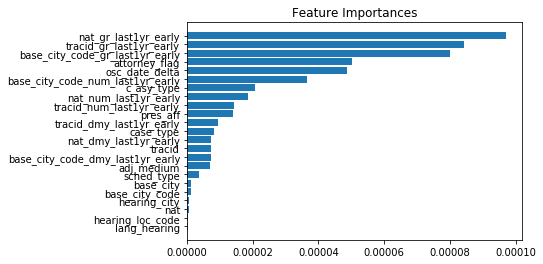

In [103]:
# simplify feature weights--sum together all weights for a given category (all nationalities)

num_features = num_pipeline.named_steps['selector'].get_feature_names()
cat_features = cat_pipeline_reg.named_steps['labeler'].get_feature_names()
cat_classes = cat_pipeline_reg.named_steps['labeler'].get_orig_classes()
attributes = np.append(num_features,pd.unique(cat_classes)) 
attributes_long = num_features + cat_classes #for each of >1000 feature, lists original feature name, i.e. nat or tracid
feature_weight_simple = np.zeros(len(attributes))
for i in range(len(attributes)):
    weights = feature_weight[[x == attributes[i] for x in attributes_long]]
    feature_weight_simple[i] = np.mean(weights)
    
indices = np.argsort(feature_weight_simple)
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_weight_simple[indices], align='center')
plt.yticks(range(len(indices)), [attributes[i] for i in indices])


## Evaluate on Test Set

In [ ]:
test = file[file.idncase.isin(test_cases.num)] #don't need this now
test_data = clean.transform(test)
y_test = test_data['dec']
X_test = test_data.drop(columns=['dec'], axis=1)
X_test_tr = full_pipeline.transform(X_test)

In [ ]:
#num_features = num_pipeline.named_steps['selector'].get_feature_names()
#cat_features = cat_pipeline.named_steps['labeler'].get_feature_names()

In [ ]:
print(final_model.score(X_test_tr, y_test))

## Hyperparameter Grid Search On Decision Tree

In [59]:
X_train_tr = full_pipeline.fit_transform(X_train)

In [61]:
param_grid_dt = {"max_depth": [10, 5, 3, 1, None],
        "max_features": randint(1, min(20,X_train_tr.shape[1]-1)),
        "min_samples_leaf": randint(1, 20),
        "criterion": ["gini", "entropy"]}

In [62]:
dec_tree = DecisionTreeClassifier()
grid_search_dt = RandomizedSearchCV(dec_tree, param_grid_dt, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_dt.fit(X_train_tr, y_train)
result = pd.DataFrame(grid_search_dt.cv_results_)
print(result)

   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       0.953832         0.110080         0.655707          0.763854   
1       1.909836         0.136338         0.630299          0.752670   
2       1.818806         0.163459         0.651519          0.879750   
3       1.009844         0.094178         0.572087          0.607357   
4       1.712396         0.062882         0.673123          0.817665   
5       1.075524         0.067035         0.601877          0.711458   
6       0.933877         0.088933         0.603698          0.707013   
7       0.861367         0.136385         0.543261          0.607910   
8       1.334851         0.082000         0.667590          0.813420   
9       0.838890         0.059585         0.653073          0.771945   

  param_criterion param_max_depth param_max_features param_min_samples_leaf  \
0         entropy              10                  1                     13   
1            gini               5                

In [63]:
final_model_dt = grid_search_dt.best_estimator_
print(final_model_dt.score(X_test_tr, y_test))

NameError: name 'X_test_tr' is not defined

Text(0.5,0,'Relative Importance')

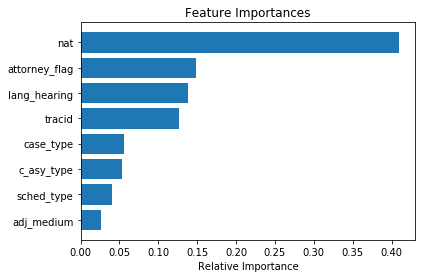

In [64]:
feature_weight_dt = grid_search_dt.best_estimator_.feature_importances_
num_features = num_pipeline.named_steps['selector'].get_feature_names()
cat_features = cat_pipeline.named_steps['selector'].get_feature_names()
attributes = num_features + cat_features
indices = np.argsort(feature_weight_dt)
ordered_attributes = [attributes[i] for i in indices]

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_weight_dt[indices], align='center')
plt.yticks(range(len(indices)), ordered_attributes)
plt.xlabel('Relative Importance')

## Hyperparameter Grid Search On Decision Tree

In [93]:
param_grid_rf = {
    'n_estimators': [100, 300, 500],
    'max_features': [2, 4, 6, 8, 10],
    'bootstrap': [False, True],
    'max_depth':[2, 4, 6, 8]
}

In [ ]:
rf = RandomForestClassifier()
grid_search_rf = RandomizedSearchCV(rf, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_rf.fit(X_train_tr, y_train)
result = pd.DataFrame(grid_search_rf.cv_results_)
print(result)

## Evaluate Random Forest Classifier on Test Set

In [ ]:
final_model_rf = grid_search_rf.best_estimator_
print(final_model_rf.score(X_test_tr, y_test))

In [ ]:
feature_weight_rf = grid_search_rf.best_estimator_.feature_importances_
indices_rf = np.argsort(feature_weight_rf)
ordered_attributes_rf = [attributes[i] for i in indices_rf]
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices_rf)), feature_weight_rf[indices_rf], align='center')
plt.yticks(range(len(indices_rf)), ordered_attributes_rf)
plt.xlabel('Relative Importance')